<a href="https://colab.research.google.com/github/MarcioB1999/Aprendizado_de_Maquina/blob/main/Regressao_pre%C3%A7o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 7.5 MB/s 
  Created wheel for pyod: filename=pyod-1.0.4-py3-none-any.whl size=165073 sha256=019c1973b6dbcad061cd90ed3b47d1f95a584c993058acbcb2f0eff1d698fea8
  Stored in directory: /root/.cache/pip/wheels/3d/48/a8/87d61660791c7e6b0f5c3068da7fb17ade7fdc041e864fe053
Successfully built pyod


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter as ct
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.neural_network import MLPRegressor as rn
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LinearRegression
import statsmodels.api as smi
from scipy import stats
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from datetime import datetime
from pyod.models.knn import KNN
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Tratamento dos Dados**

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/arquivos/kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
df['date'] = [f'{i[6:8]}'+'/'+f'{i[4:6]}'+'/'+f'{i[0:4]}' for i in df['date']]
df['date'] = [datetime.strptime(i,'%d/%m/%Y') for i in df['date']]
df['Month']=[i.month for i in df['date']]
df['Year']=[i.year for i in df['date']]
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Month,Year
0,7129300520,2014-10-13,221900.0,3.0,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,10,2014
1,6414100192,2014-12-09,538000.0,3.0,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,2014
2,5631500400,2015-02-25,180000.0,2.0,1.00,770,10000,1.0,0,0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2,2015
3,2487200875,2014-12-09,604000.0,4.0,3.00,1960,5000,1.0,0,0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,12,2014
4,1954400510,2015-02-18,510000.0,3.0,2.00,1680,8080,1.0,0,0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2015


In [7]:
#colunas excluidas manualmente é importante que tenham acompanhamento de um especialista no tema dos dados
print(df.isnull().sum())
#como existe poucos valores faltantes, irei retira-los
df.dropna(how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

id               0
date             0
price            0
bedrooms         4
bathrooms        0
sqft_living      0
sqft_lot         0
floors           1
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
Month            0
Year             0
dtype: int64


Como há poucos dados faltantes, iremos apenas excluí-los, pois não são significantes

In [8]:
colunas=['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'grade', 'Year', 'Month']
for i in colunas:
    print(f'{i}=',df[i].unique())

bedrooms= [ 3.  2.  4.  5.  1.  6.  7.  0.  8.  9. 11. 10. 33.]
bathrooms= [1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 0.   1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75
 6.25 6.5 ]
floors= [1.  2.  1.5 3.  2.5 3.5]
waterfront= [0 1]
view= [0 3 4 2 1]
grade= [ 7  6  8 11  9  5 10 12  4  3 13  1]
Year= [2014 2015]
Month= [10 12  2  5  6  1  4  3  7  8 11  9]


Para algumas colunas podemos usar o unique para visualizar se tem algum valor inconsistente, como por exemplo bathrooms=2.25
oque não faz sentido, necessitando converter para inteiro


In [11]:
df['bathrooms']=df['bathrooms'].astype('int')
df['floors']=df['floors'].astype('int')
colunas=['bathrooms', 'floors']
for i in colunas:
    print(f'{i}=',df[i].unique())

bathrooms= [1 2 3 4 0 5 6 8 7]
floors= [1 2 3]


In [12]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Month,Year
0,7129300520,2014-10-13,221900.0,3.0,1,1180,5650,1,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,10,2014
1,6414100192,2014-12-09,538000.0,3.0,2,2570,7242,2,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,2014
2,5631500400,2015-02-25,180000.0,2.0,1,770,10000,1,0,0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2,2015
3,2487200875,2014-12-09,604000.0,4.0,3,1960,5000,1,0,0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,12,2014
4,1954400510,2015-02-18,510000.0,3.0,2,1680,8080,1,0,0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2015


# **Analise do Faturamento Durante o Tempo**

In [13]:
data_series=df[['date','price']]
data_series.sort_values('date',inplace=True)
data_series.set_index('date', inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


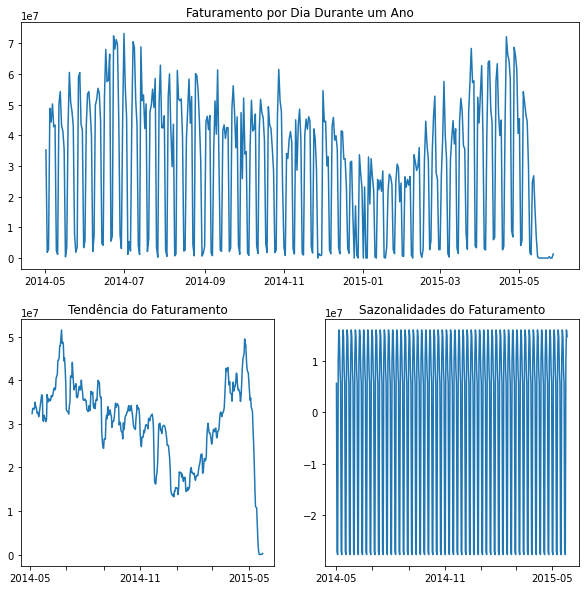

In [14]:
data_series_day=data_series.resample('D').sum()

decomposicao = seasonal_decompose(data_series_day)
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal

fig=plt.figure(figsize=(10,10))

ax=fig.add_subplot(2,1,1)
ax.set_title('Faturamento por Dia Durante um Ano')
plt.plot(data_series_day)

ax=fig.add_subplot(2,2,3)

ax.set_title('Tendência do Faturamento')
plt.plot(tendencia)
for i,tick in enumerate(ax.xaxis.get_ticklabels()):
    if i == 0 or i == 3 or i == 6:
        tick.set_visible(True)
    else:
        tick.set_visible(False)


ax=fig.add_subplot(2,2,4)
ax.set_title('Sazonalidades do Faturamento')
plt.plot(sazonal)
for i,tick in enumerate(ax.xaxis.get_ticklabels()):
    if i == 0 or i == 3 or i == 6:
        tick.set_visible(True)
    else:
        tick.set_visible(False)

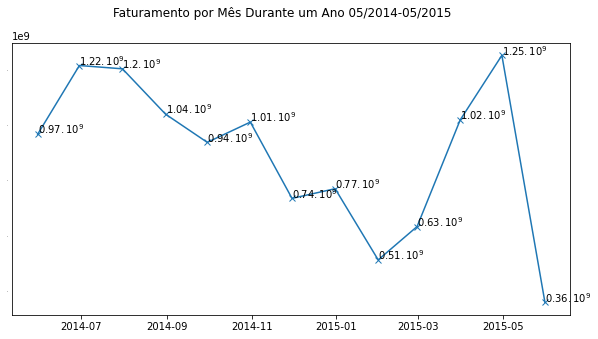

In [15]:
fig=plt.figure(figsize=(10,5))


#------------------------------------------------------------------
ax=fig.add_subplot(1,1,1)
fig.suptitle('Faturamento por Mês Durante um Ano 05/2014-05/2015')

data_series_mes=data_series.resample('M').sum()
plt.plot(data_series_mes, 'x-')

plt.tick_params(axis='y', labelsize=0, length=0)
aux=[datetime.strptime(i.isoformat()[:10],'%Y-%m-%d') for i in data_series_mes.index]
for i in aux:
    plt.text(i, data_series_mes.loc[i], f"{round(data_series_mes.loc[i].values[0]/1000000000,2)}"+r'$.10^{9}$')

Conseguimos ver uma tendência de queda entre 06/2014-01/2015. Por ser apenas uma ano, não conseguimos aplicar a decomposição para analisar a tendencia geral em relação ao ano, e nem a sazonalidade

# Funções auxiliares 

In [16]:
def prob(data, acu):
    aux=np.zeros(data.shape[0])
    
    #marcando no data frame valores que estao no vetor de acumulados
    data_aux=data.isin({'price':acu})
    
    
    #pegando os indices dos valores que estao no vetor acumulados
    indices=data[data_aux.price].index

    for i in indices:
        aux[i]=1
    return aux

In [17]:
def acumulativo(serie, porcentagem):
    #essa função recebe uma serie e porcentagem, e retornará um vetor tal que a soma de suas
    #frequencias sejam <=porcentagem, alem da soma das probabilidades desses valores e o maior a aparecer
    #obs: valores em vec não se repetem
    vec=[]
    cont=serie.value_counts(normalize=True)
    values=pd.DataFrame(cont.index)
    #ordenando os valores, pois se nao pegar na ordem de menor para maior valor de price, acabará pulando valores
    #na contagem do acumulado
    order=pd.DataFrame(values.sort_values(by=0, ascending=True).reset_index(drop=True))
    acu=0
    for i in order.values:
        value=i[0]
        acu+=cont.loc[value]
        if(acu>porcentagem):
            break
        else:
            vec.append(value)
    return np.resize(vec,(serie.shape[0])), acu, max(vec)[0]
            
          

# **Visuzalização Geral dos dados**

Vamos verificar a distribuição do preço, não apenas para a regressão, mas tambem para os tratamentos dos seu valores como outliers

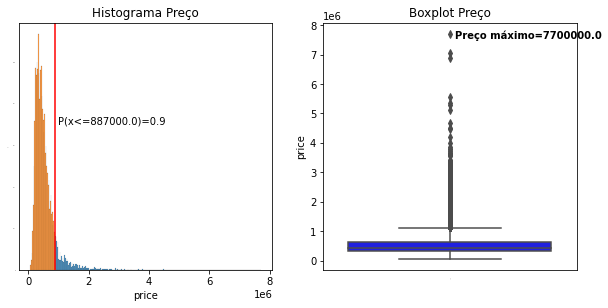

In [18]:
#fazendo uma copia com apenas a coluna que interessa
df_aux=df['price'].copy()
df_aux=pd.DataFrame(df_aux)

#fator de probabilidade
probi=0.9

#funções auxiliares
aux, acu, maxi=acumulativo(df_aux, probi)
df_aux.insert(1,'bool',prob(df_aux, aux))


fig=plt.figure(figsize=(10,10))


#histograma
ax=fig.add_subplot(2,2,1)
ax.set_title('Histograma Preço')
sns.histplot(data=df_aux[["price","bool"]],x="price",hue="bool",multiple="stack", legend=False)
plt.ylabel([], fontsize=0)
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)
plt.axvline(x=maxi, ymin=0, ymax=700, color='red')
plt.text(maxi+100000, 700, f"""P(x<={maxi})={probi}""")



#boxplot
ax=fig.add_subplot(2,2,2)
ax.set_title('Boxplot Preço')
sns.boxplot(y="price",data=df,color='blue')
plt.xlabel([], fontsize=0)
plt.tick_params(axis='x', labelsize=0, length=0)

maximo=df['price'].max()
plt.text(0.02, maximo-150000, f"Preço máximo={maximo}", weight="bold")

plt.show()

Podemos ver muitos valores identificados como outliers, contudo elas são representativas de uma parte da população de preço de casas. Não é como se tivesse uma ou três casas caras no meio de milhares baratas que poderiam ser problemáticas para os modelos. E como estamos pensando, é normal estes dados serem assim, pois estamos supondo que os dados de preços dependem de outras variaveis, ou seja, eles provem de distribuições diferentes.

##Testes de Normalidade Para Preço

testes de normalidade para se verificar a distribuição do preço, é importante para se aplicar testes, e métodos adequados, pois alguns so funcionam com a suposição de normalidade

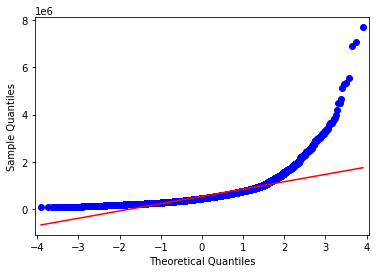

In [19]:
smi.qqplot(df["price"], line = "r")
plt.show()

In [20]:
stat_test, p_valor =stats.normaltest(df["price"])
alpha=0.05
if p_valor < alpha:  # hipotese nula: x vem de uma distribuição normal
    print("A hipotese nula pode ser rejeitada")
else:
    print("A hipotese nula não pode ser rejeitada")

A hipotese nula pode ser rejeitada


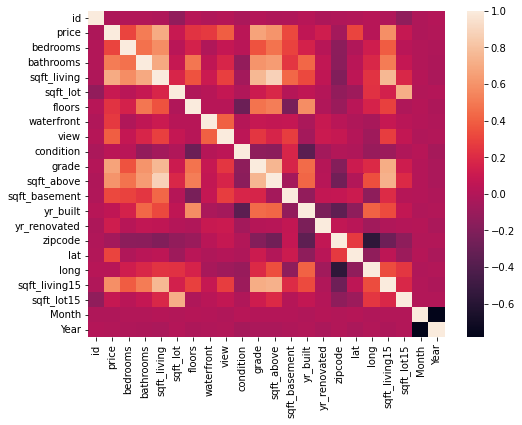

In [21]:

corr_df = df.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=False)
plt.show()

Text(0.5, 0, 'sqft_living')

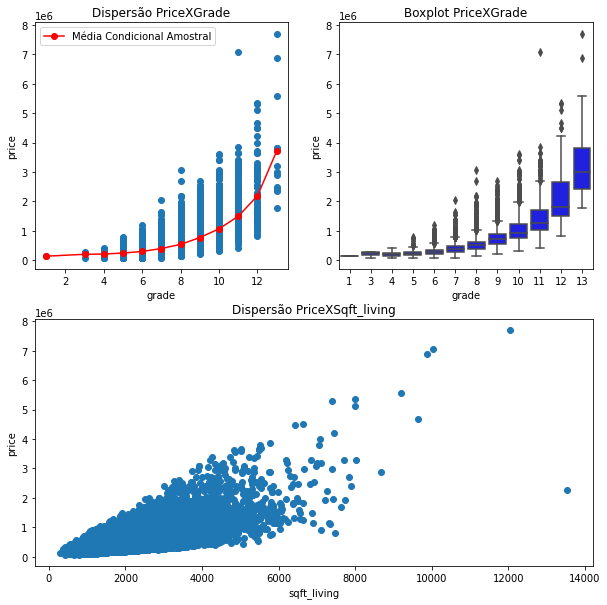

In [22]:
grop=df[['grade','price']].groupby('grade').mean()

fig=plt.figure(figsize=(10,10))

ax=fig.add_subplot(2,2,1)
plt.plot(grop.index,grop.price, 'o-', color='red',label='Média Condicional Amostral')
plt.legend()
ax.set_title('Dispersão PriceXGrade')
plt.scatter(df.grade,df.price)
plt.ylabel('price')
plt.xlabel('grade')


ax=fig.add_subplot(2,2,2)
ax.set_title('Boxplot PriceXGrade')
sns.boxplot(x="grade",y="price",data=df,color='blue')






ax=fig.add_subplot(2,1,2)
ax.set_title('Dispersão PriceXSqft_living')
plt.scatter(df.sqft_living,df.price)
plt.ylabel('price')
plt.xlabel('sqft_living')






Percebemos que se no começo tivessemos feito algum tratamento nos dados dos preço, não veriamos certas caracteristicas da variavel.
No primeiro caso temos uma correlação parecida com uma exponencial, enquanto a segunda é mais parecida com uma reta. Pelo fato da função de regressão tentar prever o valor esperado condicional de y, plotamos a média condicional amostral no primeiro caso para ter uma ideia.

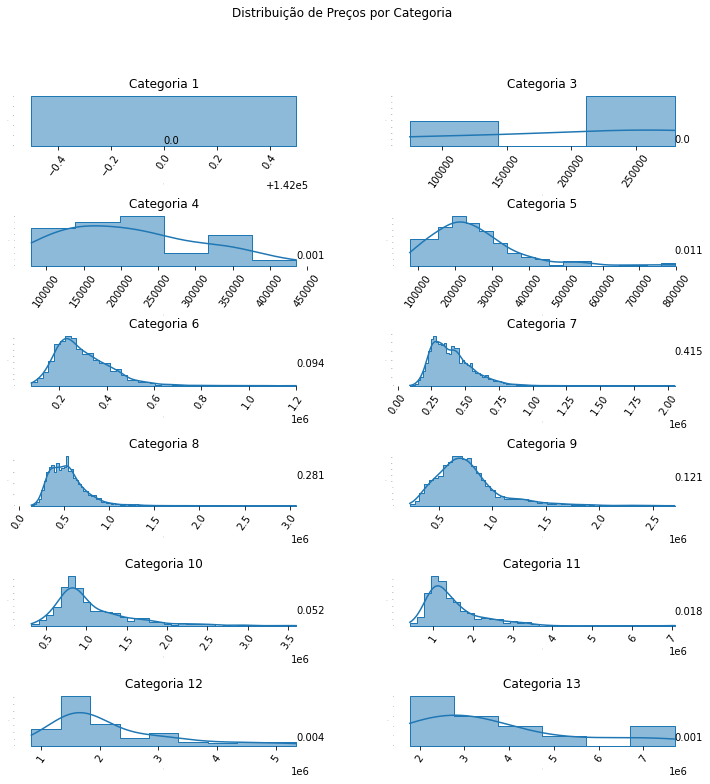

In [23]:
fig=plt.figure(figsize=(12,12))

plt.subplots_adjust(wspace=0.3, hspace=1.3)

#pega a frequencia
cont=df['grade'].value_counts(normalize=True)


#pegar o preço mais alto de cada grade
grop=df[['grade','price']].groupby('grade').max()

#pegar a frequencia de cada preço por grade
grop2=df[['grade','price']].groupby(['grade', 'price']).size()

#colocando em ordem o vetor de valores unicos de grade
value=pd.DataFrame(df['grade'].unique()).sort_values(by=0, ascending=True).values
value=np.array(value).reshape(-1)

j=0
for i in value:
    j += 1
    ax = fig.add_subplot(6,2,j)
    sns.histplot(df[df.grade==i].price, kde=True, element='step')
    sns.despine(bottom=True, left=True)
    ax.set_title(f"Categoria {i}")

    for tick in ax.get_xticklabels():
            tick.set_rotation(55)
            
    plt.tick_params(axis='y', labelsize=0, length=0)
    plt.ylabel([], fontsize=0)
    plt.xlabel([], fontsize=0)
    probabi = cont[i]
    plt.text(grop.loc[i], (grop2.loc[i].sum())/25, f"""{round(probabi, 3)}""")
    fig.suptitle('Distribuição de Preços por Categoria')

    
plt.show()

#teste
#x=df[['grade','price']].groupby(['grade', 'price']).size()
#filtro=df.isin({'price':[250000], 'grade':[7]})
#print(df[(filtro.price) & (filtro.grade)].shape)
    

# **Rede Neural**

## Tratamento dos outliers

O método para identificar os outliers foi o do boxplot, pois não depende da distribuição da variavel. e os outliers estão sendo tratados por categoria

In [24]:
order = np.array(pd.DataFrame(df['grade'].unique()).sort_values(by=0, ascending=True)).reshape(-1)

auxiliar = df.copy()



for gd in order:
    
    ax = df.loc[df['grade']==gd,['price','grade']].copy()
    
    q3 = ax['price'].quantile(0.75)
    q1 = ax['price'].quantile(0.25)
    
    iqr = q3-q1
    lif = q1-(iqr*1.5)
    lsp = q3+(iqr*1.5)
    
    ax.loc[(ax['price']<lif) | (ax['price']>lsp),'price']=np.nan
    
    
    imputer = KNNImputer(n_neighbors=15, weights='uniform', metric='nan_euclidean')
    imputer.fit(ax)




    auxiliar.loc[df['grade']==gd,['price','grade']] = imputer.transform(ax)
    

ax2 = df.copy()
ax2['price'] = auxiliar['price']

print('Quantidade de outliers antes e depois')
    
total1=0
total2=0
for gd in order:
    ax0=df.loc[df['grade']==gd].copy()
    ax=ax2.loc[ax2['grade']==gd].copy()
    
    
    q33 = df['price'].quantile(0.75)
    q11 = df['price'].quantile(0.25)
    
    iqr1 = q33-q11
    lif1 = q11-(iqr1*1.5)
    lsp1 = q33+(iqr1*1.5)
    
    q3 = ax['price'].quantile(0.75)
    q1 = ax['price'].quantile(0.25)
    
    iqr = q3-q1
    lif = q1-(iqr*1.5)
    lsp = q3+(iqr*1.5)
    
    ax.loc[(ax['price']<lif) | (ax['price']>lsp)]=np.nan
    val1=ax['price'].isnull().sum()
    
    ax0.loc[(df['price']<lif1) | (df['price']>lsp1)]=np.nan
    val0=ax0['price'].isnull().sum()
    
    total1+=val0
    total2+=val1
    
    
    print(f"categoria {int(gd)} => {val0} | {val1}")
    
    
print(f'Total =======> {total1} | {total2} ')
    

Quantidade de outliers antes e depois
categoria 1 => 0 | 0
categoria 3 => 0 | 0
categoria 4 => 0 | 0
categoria 5 => 0 | 2
categoria 6 => 1 | 18
categoria 7 => 12 | 53
categoria 8 => 120 | 55
categoria 9 => 289 | 69
categoria 10 => 366 | 40
categoria 11 => 260 | 18
categoria 12 => 85 | 5
categoria 13 => 13 | 1
Total =======> 1146 | 261 


 Conseguimos tratar aproximadamente 77% dos outliers, de modo que não são mais outliers no novo conjunto de dados

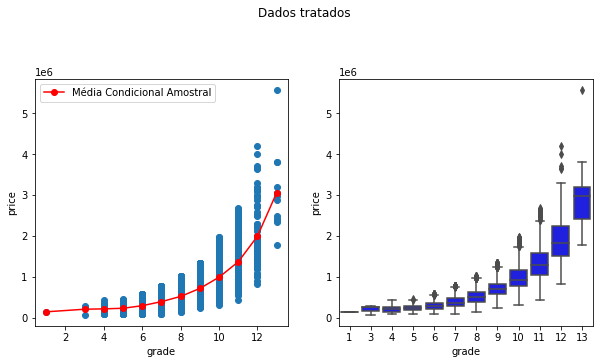

In [25]:
grop=ax2[['grade','price']].groupby('grade').mean()

fig=plt.figure(figsize=(10,10))
fig.suptitle('Dados tratados')



ax=fig.add_subplot(2,2,1)
plt.scatter(ax2.grade,ax2.price)
plt.ylabel('price')
plt.xlabel('grade')


plt.plot(grop.index,grop.price, 'o-', color='red',label='Média Condicional Amostral')
plt.legend()



ax=fig.add_subplot(2,2,2)
sns.boxplot(x="grade",y="price",data=ax2,color='blue')



Oque fizemos pode ser visto mais como uma suavização, para o modelo aprender o padrão de crescimento exponencial, isso ajuda na generalização do modelo. Pois, não há nenhum indicio desses dados realmente serem outliers, como algum erro ou evento raro que iria impactar negativamente nas analises. Se parecem mais com alguma caracteristica da população em si que deve ser considerada mais na frente pelos testes.

##**Normalização**


In [26]:

x_scale = StandardScaler()
x = ax2.grade.values
x = x.reshape(len(x),1)
x_transformed = x_scale.fit_transform(x)

y_scale = StandardScaler()
y = ax2.price.values
y = y.reshape(len(y),1)
y_transformed = y_scale.fit_transform(y)


## Rede Neural

In [27]:
rede_neural_1 = rn()
rede_neural_1.fit(x_transformed,y_transformed.ravel())
R=rede_neural_1.score(x_transformed,y_transformed.ravel())

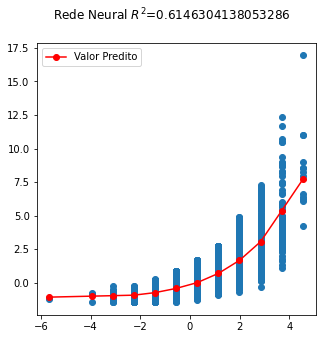

In [28]:
fig=plt.figure(figsize=(5,5))
fig.suptitle(r'Rede Neural $R^{2}$='+f'{R}')


plt.scatter(x_transformed,y_transformed)

x_aux = np.array(sorted(pd.Series(x_transformed.reshape(-1)).unique()))
x_aux = x_aux.reshape(len(x_aux),1)

y_aux = rede_neural_1.predict(x_aux)
plt.plot(x_aux,y_aux,'o-',color='red',label='Valor Predito')
plt.legend()

Modelo treinado a partir dos dados tratados, e testado com os dados tratados. Porem, suavizamos nossos dados, e não iriamos receber eles nessa mesma maneira, portanto faz mais sentido testa-lo nos dados normais sem suavização.

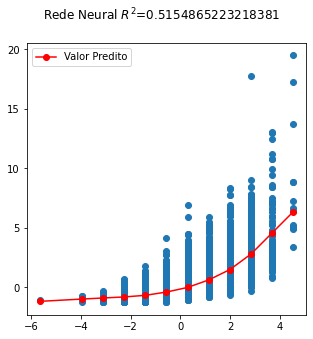

In [29]:
x_scale = StandardScaler()
x = df.grade.values
x = x.reshape(len(x),1)
x_transformed = x_scale.fit_transform(x)

y_scale = StandardScaler()
y = df.price.values
y = y.reshape(len(y),1)
y_transformed = y_scale.fit_transform(y)


rede_neural_2 = rn()
rede_neural_2.fit(x_transformed,y_transformed.ravel())
R=rede_neural_2.score(x_transformed,y_transformed.ravel())

fig=plt.figure(figsize=(5,5))
fig.suptitle(r'Rede Neural $R^{2}$='+f'{R}')


plt.scatter(x_transformed,y_transformed)

x_aux = np.array(sorted(pd.Series(x_transformed.reshape(-1)).unique()))
x_aux = x_aux.reshape(len(x_aux),1)

y_aux = rede_neural_2.predict(x_aux)
plt.plot(x_aux,y_aux,'o-',color='red',label='Valor Predito')
plt.legend()


Modelo treinado a partir dos dados não tratados, e testado com os dados não tratados. Vemos uma piora, entretanto, os dois modelos foram testados em dados diferentes. 

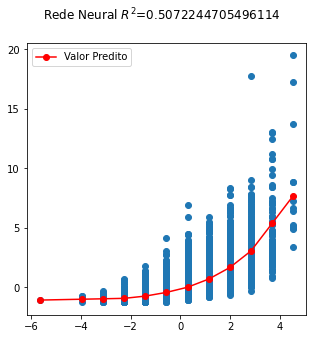

In [30]:
R=rede_neural_1.score(x_transformed,y_transformed.ravel())


fig=plt.figure(figsize=(5,5))
fig.suptitle(r'Rede Neural $R^{2}$='+f'{R}')


plt.scatter(x_transformed,y_transformed)

x_aux = np.array(sorted(pd.Series(x_transformed.reshape(-1)).unique()))
x_aux = x_aux.reshape(len(x_aux),1)

y_aux = rede_neural_1.predict(x_aux)
plt.plot(x_aux,y_aux,'o-',color='red',label='Valor Predito')
plt.legend()

Modelo treinado a partir dos dados tratados, e testado com os dados não tratados. Vemos uma piora do modelo, comparado tanto com ele mesmo para os dados tratados, quanto para o modelo treinado com os dados tratados. Porem vamos fazer testes, para ver qual se sai melhor 

##Desempenho



In [31]:

x_scale = StandardScaler()
x = ax2.grade.values
x = x.reshape(len(x),1)
x_transformed = x_scale.fit_transform(x)

y_scale1 = StandardScaler()
y_naoTratado = df.price.values
y_naoTratado = y_naoTratado.reshape(len(y),1)
y_naoTratado = y_scale1.fit_transform(y_naoTratado)


y_scale2 = StandardScaler()
y_tratado = df.price.values
y_tratado = y_tratado.reshape(len(y_naoTratado),1)
y_tratado = y_scale2.fit_transform(y_tratado)



medias_rede_neural_1 = []
#modelo treinado com dados tratados e testado com dados não tratados
for i in range(30):

    resultados = []
    for j in range(10):
        
        #para o treinamento
        X_treinamento, _, y_treinamento, _ = train_test_split(x_transformed, y_tratado.ravel(), test_size = 0.4, random_state = j+i)

        #para o teste
        _, X_teste, _, y_teste = train_test_split(x_transformed, y_naoTratado.ravel(), test_size = 0.4, random_state = j+i)


        rede_neural = rn()
        rede_neural.fit(X_treinamento,y_treinamento)

        R=rede_neural.score(X_teste,y_teste)
        resultados.append(R)
    
    medias_rede_neural_1.append(sum(resultados)/len(resultados))
    


medias_rede_neural_2 = []

for i in range(30):

    resultados = []
    for j in range(10):


        X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(x_transformed, y_naoTratado.ravel(), test_size = 0.4, random_state = j+i)


        rede_neural = rn()
        rede_neural.fit(X_treinamento,y_treinamento)

        R=rede_neural.score(X_teste,y_teste)
        resultados.append(R)
    
    medias_rede_neural_2.append(sum(resultados)/len(resultados))

In [32]:
alpha = 0.05

In [33]:
pd.Series(medias_rede_neural_1).describe()

count    30.000000
mean      0.511739
std       0.001778
min       0.506434
25%       0.511006
50%       0.511855
75%       0.512775
max       0.514646
dtype: float64

In [34]:
stat_test, p_valor =stats.normaltest(medias_rede_neural_1)
if p_valor < alpha:  # hipotese nula: x vem de uma distribuição normal
    print("A hipotese nula pode ser rejeitada")
else:
    print("A hipotese nula não pode ser rejeitada")

A hipotese nula pode ser rejeitada


In [35]:
pd.Series(medias_rede_neural_2).describe()

count    30.000000
mean      0.511715
std       0.001696
min       0.507676
25%       0.510793
50%       0.511938
75%       0.512717
max       0.515051
dtype: float64

In [36]:
stat_test, p_valor =stats.normaltest(medias_rede_neural_2)
if p_valor < alpha:  # hipotese nula: x vem de uma distribuição normal
    print("A hipotese nula pode ser rejeitada")
else:
    print("A hipotese nula não pode ser rejeitada")

A hipotese nula não pode ser rejeitada


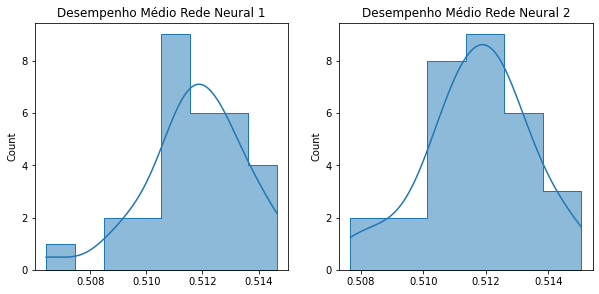

In [37]:
fig=plt.figure(figsize=(10,10))

ax=fig.add_subplot(2,2,1)
ax.set_title("Desempenho Médio Rede Neural 1")
sns.histplot(medias_rede_neural_1, kde=True, element='step')

ax=fig.add_subplot(2,2,2)
ax.set_title("Desempenho Médio Rede Neural 2")
sns.histplot(medias_rede_neural_2, kde=True, element='step')

In [38]:
_,p = f_oneway(medias_rede_neural_1,medias_rede_neural_2)

In [39]:
if p < alpha:  
    print("A hipotese nula pode ser rejeitada. Dados são diferentes")
else:
    print("A hipotese nula não pode ser rejeitada. Dados não são diferentes")

A hipotese nula não pode ser rejeitada. Dados não são diferentes


Eles não possuem diferença estatistica significativa, ou seja, tem desempenhos iguais, tanto faz qual escolher

#**Regressão** **Linear** 

##Tratamento de Outliers

detectar outliers atraves de ML

In [40]:
detector = KNN(n_neighbors=1)
detector.fit(df.iloc[:,[2,5]])
previsoes = detector.labels_

outliers_index = []
for i in range(len(previsoes)):

  if previsoes[i] == 1:
    outliers_index.append(i)

df_aux = df.copy()
df_aux['bool'] = np.zeros(len(df))
df_aux.loc[outliers_index,'bool']=1
df_aux['bool'].replace({0:'Normal',1:'Outlier'},inplace=True)

Text(0.5, 0, 'sqft_living')

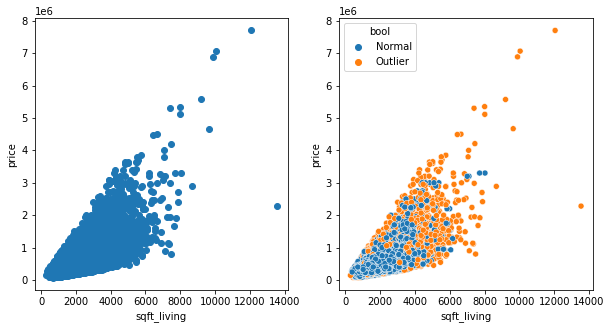

In [41]:
fig=plt.figure(figsize=(10,5))



ax = fig.add_subplot(1,2,1)
plt.scatter(df.sqft_living,df.price)

plt.ylabel('price')
plt.xlabel('sqft_living')



ax = fig.add_subplot(1,2,2)
sns.scatterplot(data=df_aux,x='sqft_living',y='price',hue='bool')

plt.ylabel('price')
plt.xlabel('sqft_living')

Os dados classificados como outliers são importante para analise, não podendo trata-los, pois ainda fazem parte de uma tendencia linear que estamos supondo. E como não há nenhum indicio de realmente serem outliers, não vamos fazer nada com eles

In [42]:
ax3 = df.copy()
ax3.loc[outliers_index,['price','sqft_living']] = np.nan
ax3.drop(columns='date',inplace=True)

In [ ]:
imputer = KNNImputer(n_neighbors=15, weights='uniform', metric='nan_euclidean')

imputer.fit(ax3)


ax3 = pd.DataFrame(imputer.transform(ax3),columns=ax3.columns)
ax3.head()

Text(0.5, 0, 'sqft_living')

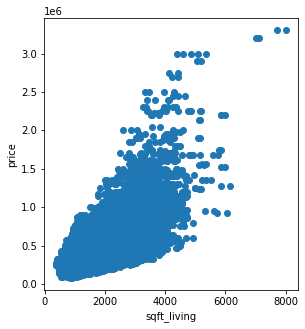

In [44]:
fig=plt.figure(figsize=(10,5))



ax = fig.add_subplot(1,2,1)
plt.scatter(ax3.sqft_living,ax3.price)

plt.ylabel('price')
plt.xlabel('sqft_living')

Ele não parece mais tanto linear, mas sim um polinomial de grau dois provavelmente poderia ser melhor aplicado. E nosso intervalo pra previsão diminuiu, pois tirou a tendencia linear para valores de sqft_living maiores que 8000

##**Normalização**


In [58]:
x_scale = StandardScaler()
x = df.sqft_living.values
x = x.reshape(len(x),1)
x_transformed = x_scale.fit_transform(x)

y_scale = StandardScaler()
y = df.price.values
y = y.reshape(len(y),1)
y_transformed = y_scale.fit_transform(y)

foi feita regressão com rede neural para comparação

In [59]:
rede_neural=rn()
rede_neural.fit(x_transformed,y_transformed.ravel())
R=rede_neural.score(x_transformed,y_transformed.ravel())

regressão linear

In [60]:
regressao_linear = LinearRegression()
regressao_linear.fit(x_transformed,y_transformed.ravel())
R2=regressao_linear.score(x_transformed,y_transformed.ravel())

## Visualização

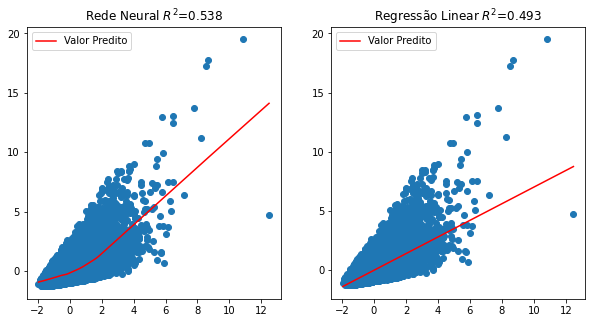

In [62]:
fig=plt.figure(figsize=(10,5))


ax = fig.add_subplot(1,2,1)
ax.set_title(r'Rede Neural $R^{2}$='+f'{round(R,3)}')

plt.scatter(x_transformed,y_transformed)

x_aux = np.array(sorted(pd.Series(x_transformed.reshape(-1)).unique()))
x_aux = x_aux.reshape(len(x_aux),1)

y_aux = rede_neural.predict(x_aux)
plt.plot(x_aux,y_aux,color='red',label='Valor Predito')
plt.legend()


ax = fig.add_subplot(1,2,2)
ax.set_title(r'Regressão Linear $R^{2}$='+f'{round(R2,3)}')

plt.scatter(x_transformed,y_transformed)

x_aux = np.array(sorted(pd.Series(x_transformed.reshape(-1)).unique()))
x_aux = x_aux.reshape(len(x_aux),1)

y_aux = regressao_linear.predict(x_aux)
plt.plot(x_aux,y_aux,color='red',label='Valor Predito')
plt.legend()


# **Usando todos atributos**

In [49]:
x_scale = StandardScaler()
x = df.loc[:,'bedrooms':'Year'].values
x_transformed = x_scale.fit_transform(x)

y_scale = StandardScaler()
y = df.price.values
y = y.reshape(len(y),1)
y_transformed = y_scale.fit_transform(y)

In [50]:
pca = PCA(0.95)

x_pca = pca.fit_transform(x_transformed)

In [51]:
rede_neural = rn(hidden_layer_sizes=(9,9),max_iter=1000)
rede_neural.fit(x_pca,y_transformed.ravel())
rede_neural.score(x_pca,y_transformed.ravel())

0.8919430129933512

In [ ]:
resultados_rede_neural = []

for i in range(30):
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    rede_neural = rn()
    scores = cross_val_score(rede_neural, x_transformed, y_transformed.ravel(), cv = kfold)
    resultados_rede_neural.append(scores.mean())

In [55]:
pd.Series(resultados_rede_neural).describe()

count    30.000000
mean      0.881146
std       0.001478
min       0.876920
25%       0.880235
50%       0.881292
75%       0.881915
max       0.884123
dtype: float64

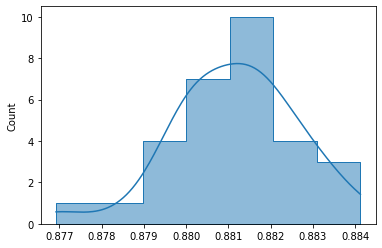

In [56]:
sns.histplot(resultados_rede_neural, kde=True, element='step')